1. Gerekli kütüphaneler

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

2. Veriyi okuma

In [2]:
# Verileri oku
train_df = pd.read_csv("../datasets/normal/train_mental.csv")
test_df = pd.read_csv("../datasets/normal/test_mental.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("treatment", axis=1)
y_train = train_df["treatment"]

X_test = test_df.drop("treatment", axis=1)
y_test = test_df["treatment"]

# Kategorik hedefi one-hot formatına çevir
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

3. ANN modeli

In [3]:
# ANN mimarisi
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # 2 sınıf için softmax
])

# Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2025-04-22 23:43:54.247207: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-22 23:43:54.247233: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-22 23:43:54.247237: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-22 23:43:54.247252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 23:43:54.247264: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,618 (14.13 KB)

 Trainable params: 3,618 (14.13 KB)

 Non-trainable params: 0 (0.00 B)

4. Model eğitimi

In [4]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


2025-04-22 23:43:54.641307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5727 - loss: 0.8823 - val_accuracy: 0.6600 - val_loss: 0.6180
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6685 - loss: 0.7172 - val_accuracy: 0.7000 - val_loss: 0.5911
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6481 - loss: 0.7375 - val_accuracy: 0.6750 - val_loss: 0.5944
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6595 - loss: 0.7013 - val_accuracy: 0.6950 - val_loss: 0.5870
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6758 - loss: 0.6602 - val_accuracy: 0.6850 - val_loss: 0.5874
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6451 - loss: 0.7104 - val_accuracy: 0.6800 - val_loss: 0.5941
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6581 - loss: 0.6772 - val_accuracy: 0.6950 - val_loss: 0.5899
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6432 - loss: 0.7014 - val_accuracy: 0.7000 - val_loss: 0.

5. Tahmin, rapor ve görselleştirme

In [5]:
# Tahmin (olasılıklar)
y_pred_proba = model.predict(X_test)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_pred_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


📋 Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0       0.66      0.71      0.68       124
           1       0.69      0.64      0.66       125

    accuracy                           0.67       249
   macro avg       0.68      0.67      0.67       249
weighted avg       0.68      0.67      0.67       249



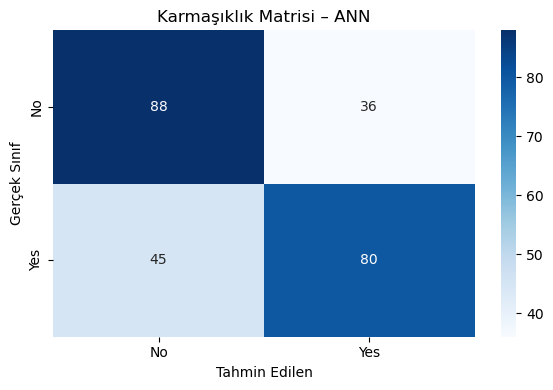

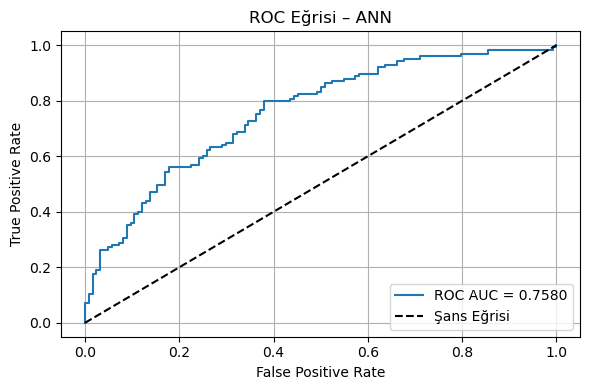

In [6]:
# Rapor
print("📋 Sınıflandırma Raporu (ANN):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# Sadece pozitif sınıfın (1) olasılığı alınır
y_score = y_pred_proba[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Çizim
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Şans Eğrisi")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()